## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

Adding features to this dataset can help us better understand it. Let's start with some simple calendar features like day of week and time of day. 

In [1]:
import pandas as pd
import holidays
import statsmodels.api as sm
import matplotlib.pyplot as plt
#import seaborn as sns
from statsmodels.tsa.seasonal import STL
from darts import TimeSeries
from darts.metrics import mape, rmse, mae


# Create a DataFrame from Load source
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")
load2024 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2024.csv", delimiter=",")
load_df = pd.concat([load2023, load2024], ignore_index=True)

# Read temperature data
weather_data = pd.read_csv("Temperature Data/smhi-opendata_1_98230_202301_202412.csv", delimiter=";", skiprows=9)

# Process load data
load_df['Time (UTC)'] = load_df['Time (UTC)'].str.split(' - ').str[0]
#load_df = load_df.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3', axis=1)   
load_df = load_df.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load'})
load_df['datetime'] = pd.to_datetime(load_df['completetime'], format='%d.%m.%Y %H:%M')
load_df = load_df.drop(['completetime'], axis=1)

# Create datetime in weather_data - adjust column names as needed
date_col = 'Datum'  # Adjust this to your actual date column name
time_col = 'Tid (UTC)'  # Adjust this to your actual time column name

# Create datetime column in weather_data by combining date and time
weather_data['datetime'] = pd.to_datetime(
    weather_data[date_col].astype(str) + ' ' + weather_data[time_col].astype(str)
)

# Create a temporary dataframe with just datetime and temperature
temp_df = weather_data[['datetime', 'Lufttemperatur']].copy()
temp_df.rename(columns={'Lufttemperatur': 'Temperature'}, inplace=True)


# Remove any duplicates in temperature data
if temp_df['datetime'].duplicated().any():
    print(f"Found {temp_df['datetime'].duplicated().sum()} duplicate timestamps in temperature data Stockholm")
    temp_df = temp_df.drop_duplicates(subset=['datetime'])

# Merge the dataframes based on datetime
print(f"Load data shape before merge: {load_df.shape}")
load_df = load_df.merge(temp_df, on='datetime', how='left')
print(f"Load data shape after merge: {load_df.shape}")


# Check for missing temperature values and identify where they are
missing_temp = load_df['Temperature'].isna().sum()
print(f"\nMissing temperature values after merge: {missing_temp}")

if missing_temp > 0:
    # Find rows with missing temperature values
    missing_rows = load_df[load_df['Temperature'].isna()]
    
    # Display information about the missing data
    print("\nRows with missing temperature values:")
    print(f"Total missing values: {len(missing_rows)}")
    
    # Show the first few rows with missing values
    print("\nFirst 10 rows with missing temperature values:")
    print(missing_rows[['datetime', 'Load']].head(10))
    
    # Show the distribution of missing values by month and hour
    print("\nMissing values by month:")
    print(missing_rows['datetime'].dt.month.value_counts().sort_index())
    
    print("\nMissing values by hour of day:")
    print(missing_rows['datetime'].dt.hour.value_counts().sort_index())
    
    # Check if missing values are consecutive
    missing_rows_sorted = missing_rows.sort_values('datetime')
    time_diff = missing_rows_sorted['datetime'].diff()
    
    print("\nTime differences between consecutive missing values (first 10):")
    print(time_diff.head(10))
    
    # Identify gaps in temperature data
    common_diff = time_diff.mode()[0]
    print(f"Most common time difference between missing values: {common_diff}")
    
    # Set datetime as index for time-based interpolation
    load_df_temp = load_df.set_index('datetime')
    
    # Perform interpolation
    load_df_temp['Temperature'] = load_df_temp['Temperature'].interpolate(method='time')
    
    # Handle any remaining missing values
    load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')
    
    # Reset index
    load_df = load_df_temp.reset_index()
    
    print(f"\nRemaining missing values after interpolation: {load_df['Temperature'].isna().sum()}")

# Adding day type
load_df['Month'] = load_df['datetime'].dt.month
load_df['Day_of_week'] = load_df['datetime'].dt.dayofweek
load_df['Hour_of_day'] = load_df['datetime'].dt.hour

# change column name
load_df['entso-e_forecast']=load_df['Day-ahead Total Load Forecast [MW] - BZN|SE3']
# Adding Holidays (excluding Sundays)
Sweden_holidays = holidays.CountryHoliday('SE')
load_df['Holidays'] = [int((date in Sweden_holidays) and date.weekday() != 6) for date in load_df.datetime]
#load_df['Holidays'] = [int(date in Sweden_holidays) for date in load_df.datetime]
# Reorder columns
load_df = load_df[['datetime', 'entso-e_forecast','Load', 'Temperature', 'Month','Day_of_week', 'Hour_of_day', 'Holidays']]

# Display a sample of the final dataframe
print("\nFinal dataframe sample:")
print(load_df.head())

# Convert the panda data frame into DART dataseries
Load = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Load"]
)

Temp = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Temperature"]
)

Holidays = TimeSeries.from_dataframe(
    df=load_df,
    time_col="datetime",
    value_cols=["Holidays"]
)

load_df



Load data shape before merge: (17544, 3)
Load data shape after merge: (17544, 4)

Missing temperature values after merge: 9

Rows with missing temperature values:
Total missing values: 9

First 10 rows with missing temperature values:
                 datetime   Load
6800  2023-10-11 08:00:00   9888
6801  2023-10-11 09:00:00   9850
6802  2023-10-11 10:00:00   9679
6803  2023-10-11 11:00:00   9544
6805  2023-10-11 13:00:00   9245
6943  2023-10-17 07:00:00  10537
6944  2023-10-17 08:00:00  10341
14983 2024-09-16 07:00:00   9398
14984 2024-09-16 08:00:00   9359

Missing values by month:
datetime
9     2
10    7
Name: count, dtype: int64

Missing values by hour of day:
datetime
7     2
8     3
9     1
10    1
11    1
13    1
Name: count, dtype: int64

Time differences between consecutive missing values (first 10):
6800                  NaT
6801      0 days 01:00:00
6802      0 days 01:00:00
6803      0 days 01:00:00
6805      0 days 02:00:00
6943      5 days 18:00:00
6944      0 days 01:00

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13244\1951307267.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  load_df_temp['Temperature'] = load_df_temp['Temperature'].fillna(method='ffill').fillna(method='bfill')


,datetime,entso-e_forecast,Load,Temperature,Month,Day_of_week,Hour_of_day,Holidays
0,2023-01-01 00:00:00,8897,8943,3.6,1,6,0,0
1,2023-01-01 01:00:00,8836,8929,3.0,1,6,1,0
2,2023-01-01 02:00:00,8779,8887,2.6,1,6,2,0
3,2023-01-01 03:00:00,8806,8859,2.4,1,6,3,0
4,2023-01-01 04:00:00,8958,8880,2.0,1,6,4,0
...,...,...,...,...,...,...,...,...
17539,2024-12-31 19:00:00,10929,11092,-2.1,12,1,19,1
17540,2024-12-31 20:00:00,10568,10798,-1.8,12,1,20,1
17541,2024-12-31 21:00:00,10272,10531,-3.0,12,1,21,1
17542,2024-12-31 22:00:00,9981,10165,-2.7,12,1,22,1


In [2]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from darts.models import CatBoostModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV

# Make sure datetime is parsed
#load_df['datetime'] = pd.to_datetime(load_df['datetime'])
load_df = load_df.set_index('datetime')

# Define Features and Target
#X = load_df[['Day_of_week', 'Hour_of_day']]
#X = load_df[['Day_of_week', 'Hour_of_day', 'Holidays']]
#X = load_df[['Temperature', 'Day_of_week', 'Hour_of_day']]
X = load_df[['Temperature', 'Day_of_week', 'Hour_of_day', 'Holidays', 'Month']]
y = load_df['Load']

# Split data (no shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# --- Train CatBoost ---
param_grid = {'depth': [4, 5, 6],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [500, 1000, 3000]
              }

# Use MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Must be negative for GridSearchCV

# Run GridSearchCV
cat_model = GridSearchCV(
    CatBoostRegressor(silent=True),
    param_grid,
    scoring=mae_scorer,
    cv=3,  # 3-fold cross-validation
    verbose=100,

)
cat_model.fit(X_train, y_train)

# Best model
best_model = cat_model.best_estimator_
print("Best Parameters:", cat_model.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=4, iterations=500, learning_rate=0.01................
[CV 1/3; 1/27] END depth=4, iterations=500, learning_rate=0.01;, score=-467.281 total time=   0.6s
[CV 2/3; 1/27] START depth=4, iterations=500, learning_rate=0.01................
[CV 2/3; 1/27] END depth=4, iterations=500, learning_rate=0.01;, score=-1452.068 total time=   0.6s
[CV 3/3; 1/27] START depth=4, iterations=500, learning_rate=0.01................
[CV 3/3; 1/27] END depth=4, iterations=500, learning_rate=0.01;, score=-470.744 total time=   0.6s
[CV 1/3; 2/27] START depth=4, iterations=500, learning_rate=0.05................
[CV 1/3; 2/27] END depth=4, iterations=500, learning_rate=0.05;, score=-449.152 total time=   0.8s
[CV 2/3; 2/27] START depth=4, iterations=500, learning_rate=0.05................
[CV 2/3; 2/27] END depth=4, iterations=500, learning_rate=0.05;, score=-1390.617 total time=   0.6s
[CV 3/3; 2/27] START depth=4, iterati

In [5]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate both MAE and MAPE
mae_cat = mean_absolute_error(y_test, y_pred)
mape_cat = mean_absolute_percentage_error(y_test, y_pred)
print(f"Lowest MAE: {mae_cat:.2f}")
print(f"Corresponding MAPE: {mape_cat:.4f}")

Lowest MAE: 338.68
Corresponding MAPE: 0.0358


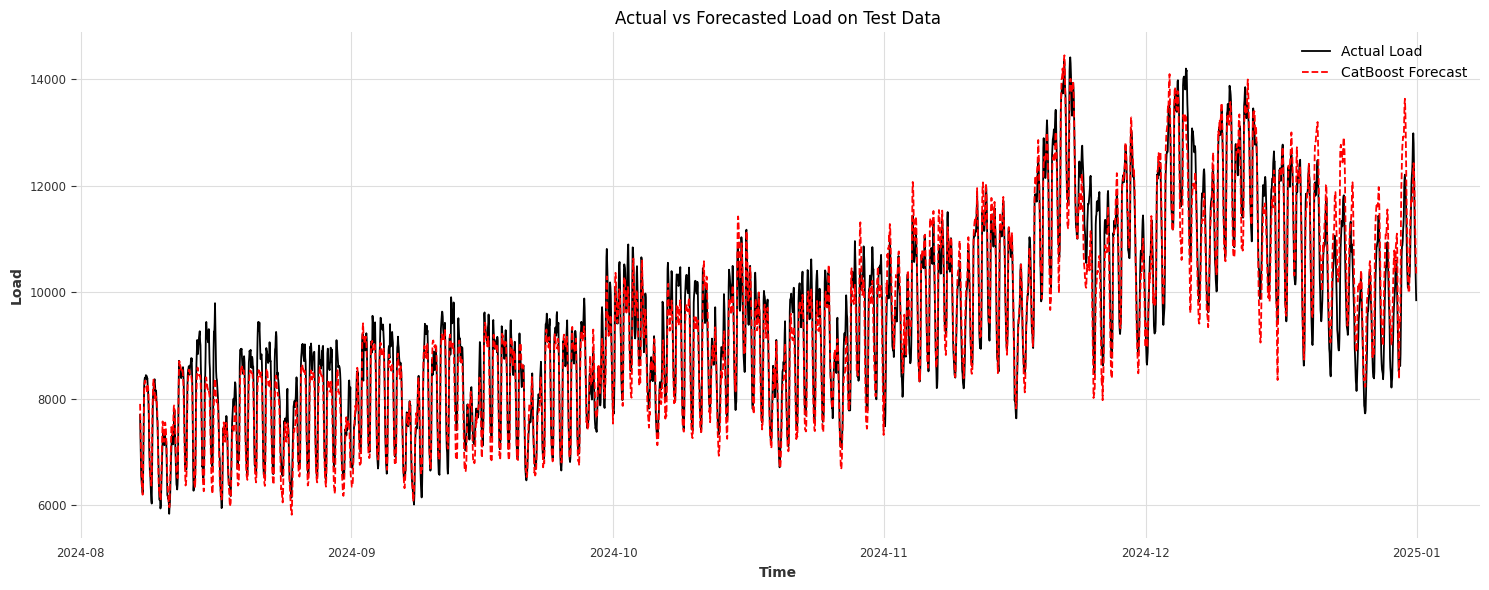

In [6]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y_test.index, y_test, label='Actual Load', color='black')
plt.plot(y_test.index, y_pred, label='CatBoost Forecast', color= 'red', linestyle='--')
plt.title('Actual vs Forecasted Load on Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Plot Results ---
plt.figure(figsize=(15,6))
plt.plot(y_train.index, y_train, label='Actual Load', color='black')
plt.plot(y_train.index, cat_pred_train, label='CatBoost Forecast', color= 'blue', linestyle='--')
plt.title('Actual vs Forecasted Load on Train Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

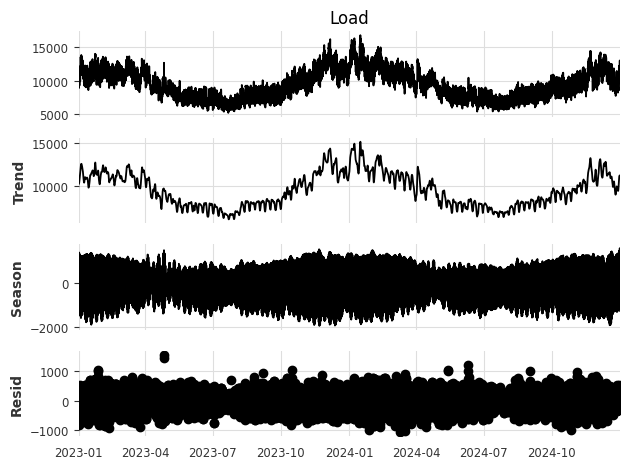

In [10]:
result = STL(load_df['Load'], period=24).fit()
_ = result.plot()

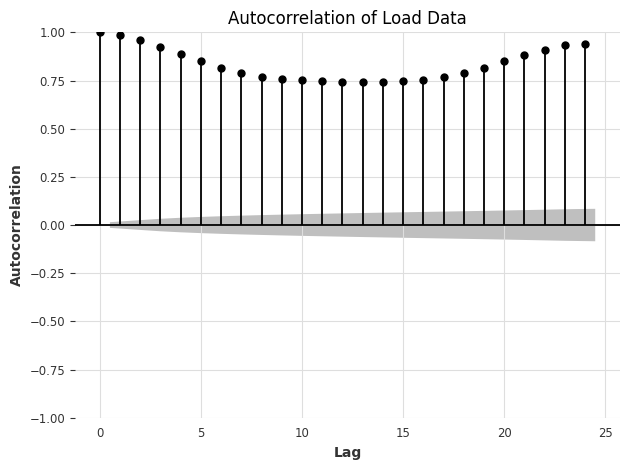

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the ACF
plot_acf(load_df['Load'], lags=24)  # You can adjust the lags value as needed
plt.title('Autocorrelation of Load Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()

Predict 24 hours ahead

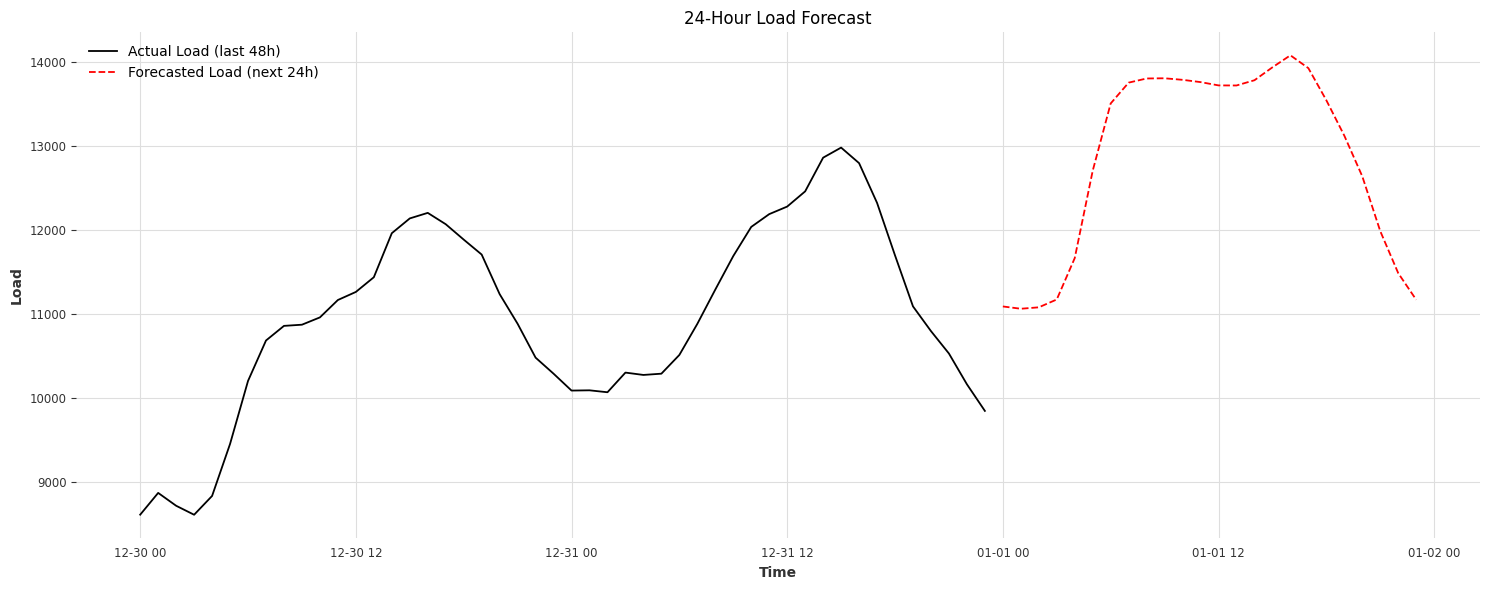

In [7]:
last_known = load_df.iloc[-24:].copy()  # Get last 24 rows
future_predictions = []
current_time = load_df.index[-1]

for step in range(24):
    # Step 1: Generate future time
    current_time += pd.Timedelta(hours=1)
    hour = current_time.hour
    day_of_week = current_time.dayofweek
    holiday = 1 if current_time.date() in load_df[load_df['Holidays'] == 1].index.date else 0
    month = current_time.month
    temp = last_known['Temperature'].iloc[-1]  # or use weather forecast
    
    # Step 2: Prepare input
    lag_1 = last_known['Load'].iloc[-1]
    lag_24 = last_known['Load'].iloc[-24] if len(last_known) >= 24 else lag_1
    rolling = last_known['Load'].iloc[-24:].mean()
    
    x_input = pd.DataFrame([{
        'Temperature': temp,
        'Day_of_week': day_of_week,
        'Hour_of_day': hour,
        'Holidays': holiday,
        'Month' : month,
        'lag_1': lag_1,
        'lag_24': lag_24,
        'rolling_mean_24': rolling
    }])
    
    # Step 3: Predict and store
    y_pred_24 = best_model.predict(x_input)[0]
    future_predictions.append((current_time, y_pred_24))
    
    # Step 4: Update last_known to include new prediction
    new_row = pd.DataFrame({
        'Load': [y_pred_24],
        'Temperature': [temp],
        'Day_of_week': [day_of_week],
        'Hour_of_day': [hour],
        'Holidays': [holiday],
        'Month': [month]
    }, index=[current_time])
    
    # Add lag/rolling info (placeholders for consistency)
    new_row['lag_1'] = lag_1
    new_row['lag_24'] = lag_24
    new_row['rolling_mean_24'] = rolling
    
    last_known = pd.concat([last_known, new_row]).iloc[1:]  # Keep size steady

# 3. Plot the forecast
forecast_index, forecast_values = zip(*future_predictions)
plt.figure(figsize=(15,6))
plt.plot(load_df['Load'].iloc[-48:], label='Actual Load (last 48h)', color='black')
plt.plot(forecast_index, forecast_values, label='Forecasted Load (next 24h)', linestyle='--', color='red')
plt.title('24-Hour Load Forecast')
plt.xlabel('Time')
plt.ylabel('Load')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

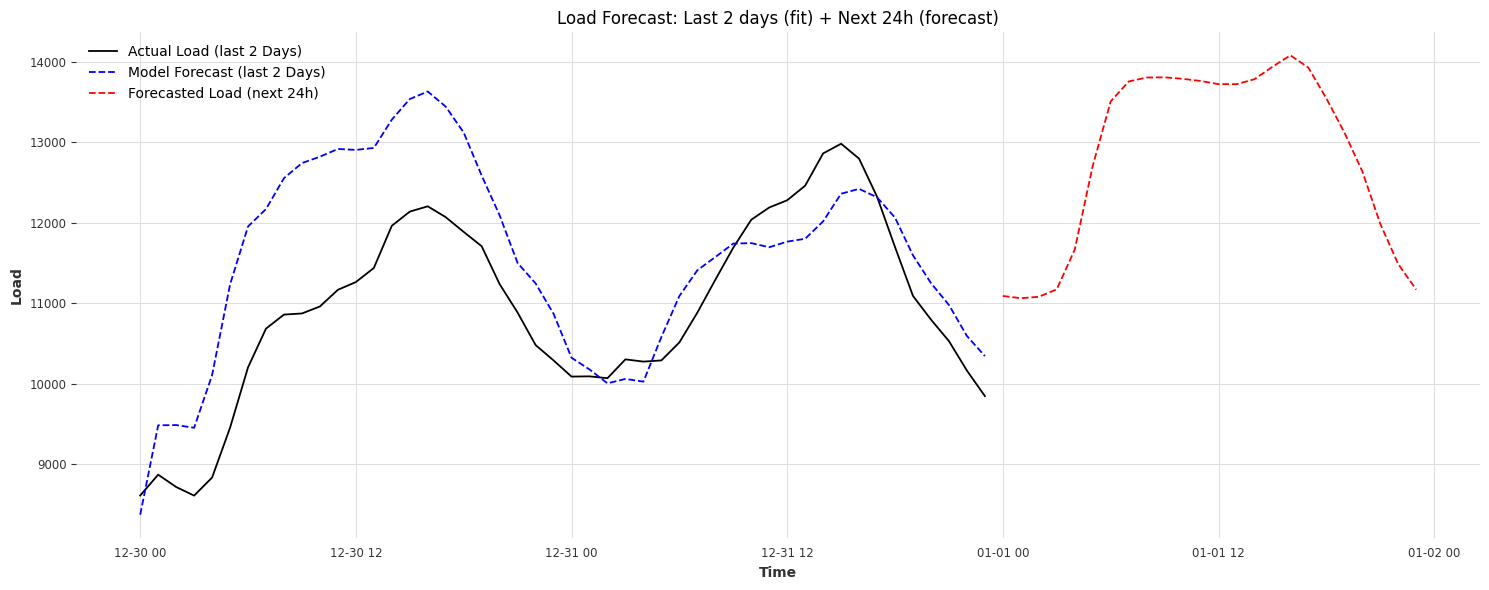

In [8]:
# 4. Predict the last 48 hours using the trained model
X_last48 = X.iloc[-48:]
y_last48_actual = y.iloc[-48:]
y_last48_pred = best_model.predict(X_last48)

# 5. Create final plot with all 3:
forecast_index, forecast_values = zip(*future_predictions)

plt.figure(figsize=(15, 6))

# Actual Load (last 1 week)
plt.plot(y_last48_actual.index, y_last48_actual, label='Actual Load (last 2 Days)', color='black')

# Model's forecast during those same 48 hours
plt.plot(y_last48_actual.index, y_last48_pred, label='Model Forecast (last 2 Days)', linestyle='--', color='blue')

# 24-hour ahead forecast
plt.plot(forecast_index, forecast_values, label='Forecasted Load (next 24h)', linestyle='--', color='red')

plt.title('Load Forecast: Last 2 days (fit) + Next 24h (forecast)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Predict on test set
#y_last168pred = best_model.predict(x_input)

# Evaluate both MAE and MAPE
mae_168 = mean_absolute_error(y_test, y_last168_pred)
mape_168 = mean_absolute_percentage_error(y_test, y_last168_pred)